## EDA

In [18]:
#importo librerias 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import scipy.stats as stats
from scipy.stats import shapiro, poisson, chisquare, expon, kstest
from itertools import combinations

In [19]:
import os

# Cargo el archivo CSV
df = pd.read_csv("bookings.csv")

In [20]:
# ANÁLISIS BÁSICO DEL DATASET BOOKINGS
print("=" * 60)
print("ANÁLISIS BÁSICO DEL DATASET")
print("=" * 60)

# Información general
print(f"\n📊 INFORMACIÓN GENERAL:")
print(f"Shape: {df.shape}")
print(f"Columnas ({df.shape[1]}): {df.columns.tolist()}")

# Tipos de datos
print(f"\n🔍 TIPOS DE DATOS:")
dtype_counts = df.dtypes.value_counts()
print(f"Distribución tipos: {dtype_counts.to_dict()}")

# Valores nulos
print(f"\n❌ VALORES NULOS:")
total_nulos = df.isnull().sum().sum()
print(f"Nulos totales: {total_nulos}")

# Duplicados
print(f"\n🔄 DUPLICADOS:")
total_duplicados = df.duplicated().sum()
print(f"Duplicados totales: {total_duplicados}")

# Valores únicos
print(f"\n🔢 VALORES ÚNICOS:")
for col in df.columns:
    unicos = df[col].nunique()
    print(f"  {col}: {unicos} únicos ({unicos/len(df)*100:.1f}%)") 

ANÁLISIS BÁSICO DEL DATASET

📊 INFORMACIÓN GENERAL:
Shape: (239400, 13)
Columnas (13): ['Booking', 'Request date', 'Requested by', 'Authorized by', 'Department', 'Currency', 'Amount', 'Reason', 'Reason 2', 'Status', 'CustomerShortname', 'CustomerRegion', 'Amount COMGES in EUR']

🔍 TIPOS DE DATOS:
Distribución tipos: {dtype('O'): 13}

❌ VALORES NULOS:
Nulos totales: 97

🔄 DUPLICADOS:
Duplicados totales: 2

🔢 VALORES ÚNICOS:
  Booking: 239393 únicos (100.0%)
  Request date: 156 únicos (0.1%)
  Requested by: 134 únicos (0.1%)
  Authorized by: 43 únicos (0.0%)
  Department: 1 únicos (0.0%)
  Currency: 26 únicos (0.0%)
  Amount: 9796 únicos (4.1%)
  Reason: 7 únicos (0.0%)
  Reason 2: 39 únicos (0.0%)
  Status: 5 únicos (0.0%)
  CustomerShortname: 687 únicos (0.3%)
  CustomerRegion: 5 únicos (0.0%)
  Amount COMGES in EUR: 9301 únicos (3.9%)


In [21]:
# Porcentaje de nulos por columna
porcentaje_nulos = (df.isnull().mean() * 100).round(2)
print(porcentaje_nulos) 

Booking                 0.00
Request date            0.00
Requested by            0.00
Authorized by           0.00
Department              0.00
Currency                0.00
Amount                  0.00
Reason                  0.00
Reason 2                0.04
Status                  0.00
CustomerShortname       0.00
CustomerRegion          0.00
Amount COMGES in EUR    0.00
dtype: float64


In [22]:
# Imputar las columnas categóricas con la moda 
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].fillna(df[col].mode()[0])

#comprobamos sumando de nuevo todos los nulos que queden
df.isnull().sum()

Booking                 0
Request date            0
Requested by            0
Authorized by           0
Department              0
Currency                0
Amount                  0
Reason                  0
Reason 2                0
Status                  0
CustomerShortname       0
CustomerRegion          0
Amount COMGES in EUR    0
dtype: int64

In [23]:
#usamos un booleano: False si es nulo
print(df.notnull())

        Booking  Request date  Requested by  Authorized by  Department  \
0          True          True          True           True        True   
1          True          True          True           True        True   
2          True          True          True           True        True   
3          True          True          True           True        True   
4          True          True          True           True        True   
...         ...           ...           ...            ...         ...   
239395     True          True          True           True        True   
239396     True          True          True           True        True   
239397     True          True          True           True        True   
239398     True          True          True           True        True   
239399     True          True          True           True        True   

        Currency  Amount  Reason  Reason 2  Status  CustomerShortname  \
0           True    True    True      

In [25]:
# Convertir columnas a numéricas
df['Amount'] = pd.to_numeric(df['Amount'].str.replace(',', '.'), errors='coerce')
df['Amount COMGES in EUR'] = pd.to_numeric(df['Amount COMGES in EUR'].str.replace(',', '.'), errors='coerce')

# Verificar los tipos
print(f"Amount: {df['Amount'].dtype}")
print(f"Amount COMGES in EUR: {df['Amount COMGES in EUR'].dtype}")

AttributeError: Can only use .str accessor with string values!

## Visualización

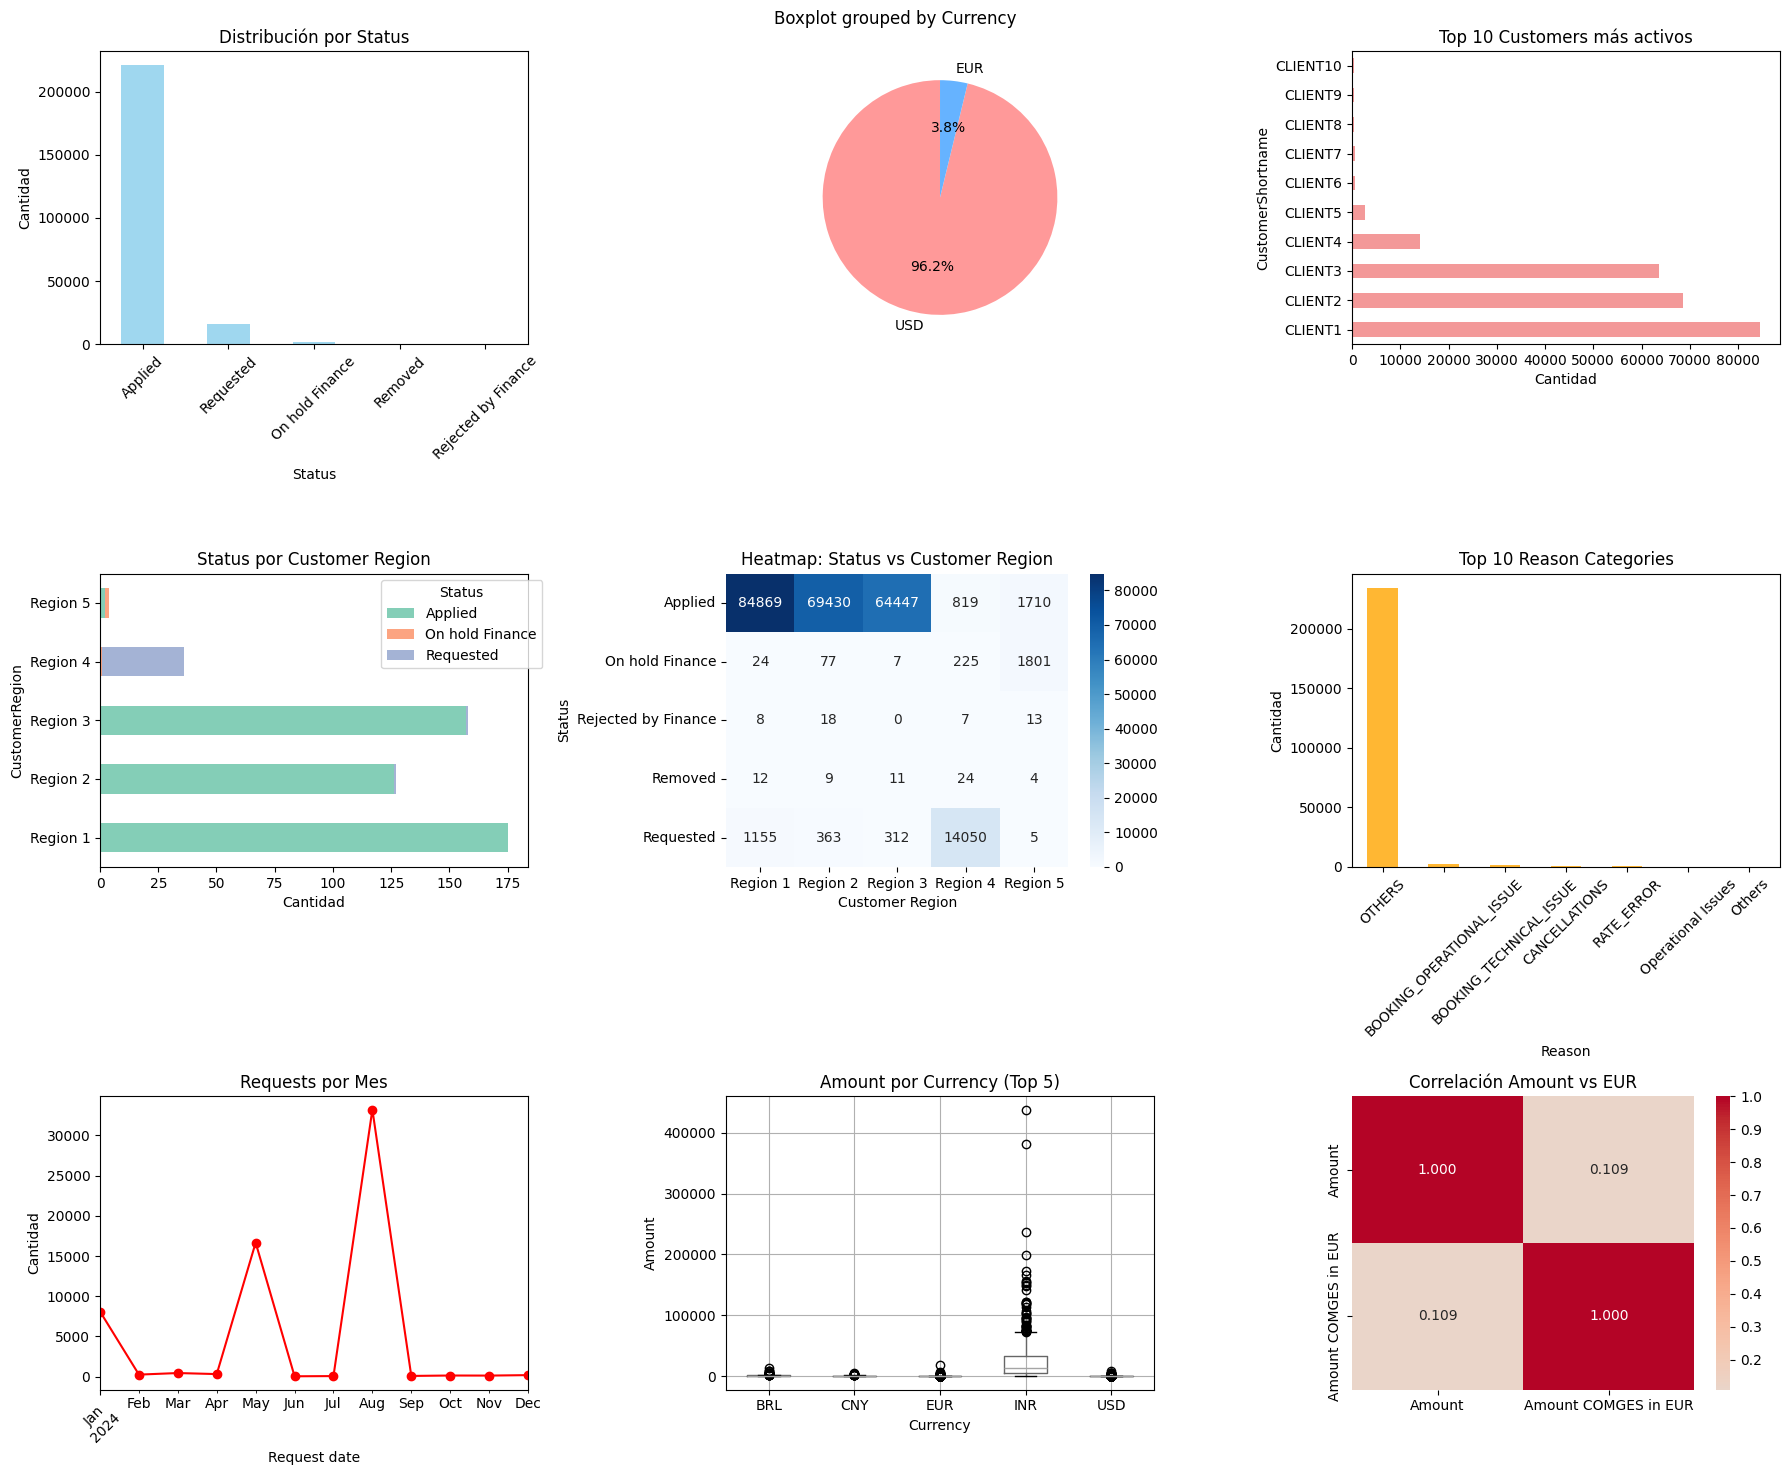

In [60]:
# Configurar estilo
plt.style.use('default')
sns.set_palette("Set2")

# Crear figura con múltiples subplots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Análisis Exploratorio - Dataset Bookings', fontsize=16, fontweight='bold')

# 1. Distribución por Status
ax1 = axes[0, 0]
status_counts = df['Status'].value_counts()
status_counts.plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)
ax1.set_title('Distribución por Status')
ax1.set_ylabel('Cantidad')
ax1.tick_params(axis='x', rotation=45)

# 2. Currency Distribution 
ax2 = axes[0, 1]
currency_counts = df['Currency'].value_counts().head(2)
colors = ['#ff9999','#66b3ff','#99ff99']
currency_counts.plot(kind='pie', ax=ax2, colors=colors, autopct='%1.1f%%', startangle=90)
ax2.set_ylabel('')

# 3. Top 10 Customers más activos
ax3 = axes[0, 2]  # ← Cambiar a posición disponible
customer_counts = df['CustomerShortname'].value_counts().head(10)
customer_counts.plot(kind='barh', ax=ax3, color='lightcoral', alpha=0.8)
ax3.set_title('Top 10 Customers más activos')
ax3.set_xlabel('Cantidad')

# 4. Count plot Status vs Region (HORIZONTAL)
ax4 = axes[1, 0]
df_sample = df.sample(n=min(500, len(df)))  # Muestra para evitar saturación
status_region = df_sample.groupby(['CustomerRegion', 'Status']).size().unstack(fill_value=0)
status_region.plot(kind='barh', ax=ax4, alpha=0.8, stacked=True)
ax4.set_title('Status por Customer Region')
ax4.set_xlabel('Cantidad')
ax4.legend(title='Status', bbox_to_anchor=(1.05, 1))

# 5. Heatmap horizontal Status vs Region
ax5 = axes[1, 1]
# Crear tabla de contingencia
heatmap_data = df.groupby(['Status', 'CustomerRegion']).size().unstack(fill_value=0)
sns.heatmap(heatmap_data, annot=True, cmap='Blues', ax=ax5, fmt='d', cbar=True)
ax5.set_title('Heatmap: Status vs Customer Region')
ax5.set_xlabel('Customer Region')
ax5.set_ylabel('Status')

# 6. Top 10 Reason Categories
ax6 = axes[1, 2]
reason_counts = df['Reason'].value_counts().head(10)
reason_counts.plot(kind='bar', ax=ax6, color='orange', alpha=0.8)
ax6.set_title('Top 10 Reason Categories')
ax6.set_ylabel('Cantidad')
ax6.tick_params(axis='x', rotation=45)

# 7. Evolución temporal de requests (si es posible)
ax7 = axes[2, 0]
try:
    df_temp = df.copy()
    df_temp['Request date'] = pd.to_datetime(df_temp['Request date'], errors='coerce')
    monthly_requests = df_temp['Request date'].dt.to_period('M').value_counts().sort_index()
    if len(monthly_requests) > 1:
        monthly_requests.plot(kind='line', marker='o', ax=ax7, color='red')
        ax7.set_title('Requests por Mes')
        ax7.set_ylabel('Cantidad')
        ax7.tick_params(axis='x', rotation=45)
    else:
        ax7.text(0.5, 0.5, 'Datos insuficientes\npara serie temporal', 
                ha='center', va='center', transform=ax7.transAxes)
        ax7.set_title('Evolución Temporal')
except:
    ax7.text(0.5, 0.5, 'Error procesando\nfechas', 
            ha='center', va='center', transform=ax7.transAxes)
    ax7.set_title('Evolución Temporal')

# 8. Boxplot Amount por Currency (top 5)
ax8 = axes[2, 1]
top_currencies = df['Currency'].value_counts().head(5).index
df_top_curr = df[df['Currency'].isin(top_currencies)]
df_top_curr.boxplot(column='Amount', by='Currency', ax=ax8)
ax8.set_title('Amount por Currency (Top 5)')
ax8.set_xlabel('Currency')
ax8.set_ylabel('Amount')

# 9. Heatmap de correlación entre variables numéricas
ax9 = axes[2, 2]
numeric_data = df[['Amount', 'Amount COMGES in EUR']].corr()
sns.heatmap(numeric_data, annot=True, cmap='coolwarm', center=0, ax=ax9, fmt='.3f')
ax9.set_title('Correlación Amount vs EUR')

plt.tight_layout()
plt.show()